In [8]:
from importlib.metadata import version

pkgs = ["matplotlib",  # to make plots like loss curves
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow" # For OpenAI's pretrained weights sicne GPT-2 was trained on TF
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 2.0.2
tiktoken version: 0.12.0
torch version: 2.9.0+cu126
tensorflow version: 2.19.0


In [36]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class LayerNormalization(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(variance + self.eps)
        return self.scale * norm_x + self.shift


class MultiHeadAttention(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.emb_dim = cfg["emb_dim"]
        self.n_heads = cfg["n_heads"]
        self.head_dim = self.emb_dim // self.n_heads
        self.qkv_proj = nn.Linear(self.emb_dim, 3 * self.emb_dim, bias=cfg["qkv_bias"])
        self.out_proj = nn.Linear(self.emb_dim, self.emb_dim)
        self.drop_out = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        batch_size, context_length, emb_dim = x.size()

        qkv = self.qkv_proj(x)
        qkv = qkv.view(batch_size, context_length, self.n_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # (batch_size, n_heads, context_length, 3 * head_dim)
        q, k, v = qkv.chunk(3, dim=-1)

        # scaled dot-product attention
        attn_scores = q @ k.transpose(2, 3) / (self.head_dim**0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.drop_out(attn_weights)

        output = (attn_weights @ v).transpose(1, 2) # (batch_size, context_length, n_heads, head_dim)
        output = output.reshape(batch_size, context_length, emb_dim)
        output = self.out_proj(output)
        return output


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            nn.GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
            nn.Dropout(cfg["drop_rate"])
        )

    def forward(self, x):
        return self.ffn(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(cfg)
        self.ffn = FeedForward(cfg)
        self.norm1 = LayerNormalization(cfg["emb_dim"])
        self.norm2 = LayerNormalization(cfg["emb_dim"])
        self.drop_out = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # x = x + self.drop_out(self.att(self.norm1(x))) # original GPT-2, w/ post-norm
        # x = x + self.drop_out(self.ffn(self.norm2(x))) # original GPT-2, w/ post-norm
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_out(x)
        x = x + shortcut # pre-norm

        shortcut = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.drop_out(x)
        x = x + shortcut # pre-norm

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNormalization(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, context_length = in_idx.size()

        tok_emb = self.tok_emb(in_idx)
        pos_emb = self.pos_emb(torch.arange(context_length, device=in_idx.device))

        x = tok_emb + pos_emb
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 254, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [51]:
# use this if we can import

import torch
from gpt_from_scratch_to_generate_texts import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 254, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [52]:
import tiktoken
from gpt_from_scratch_to_generate_texts import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension since our model
    # expects inputs to be in batch
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist()) # .tolist() converts tensor to a python list

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you poisonssetup headache missionary Governorsgee Purg salty Kramer �


We as humans can look at this text and say that this is not good enough. But, how do we quantify this in numeric form?

##Calculating the text generation loss: cross-entropy and perplexity

In [12]:
# Let's create an inputs and a targets tensor containing the token ids.

inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [13]:
inputs.shape, targets.shape

(torch.Size([2, 3]), torch.Size([2, 3]))

In [14]:
# and when we pass this to the model, we get we obtain the logits vector for the 2 input examples that consist of 3 tokens each
# Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary.
# Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores.
# for each token, the highest value in that dimensional vector is the predicted target.

with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)
probas

torch.Size([2, 3, 50257])


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

In [15]:
token_ids = torch.argmax(probas, dim=-1)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[36397, 39619, 20610],
        [ 8615, 49289, 47105]])


In [16]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Gathering SerbianFriday


We get outputs that do not make sense because we haven't trained the model yet.

To train the model, we need to know how far off it is from the actual correct predictions.



In [17]:
probas

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

In [18]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
# this tells us : for the actual correct target, how confident the model was in it's output

# so if we look at probas, we see that it gives us the probability for each word in the vocabulary
# but since the model is untrained, we do not know whether it is correct or not
# what we are essentially doing here is extracting the correct target's token id for each token
# and then getting the probability that the output gave us fort THAT token id
# if our actual target's token id was say 506, this gives us the prob that the output gave us at that position
# we can see that the prob is mostly 0 here since the model is untrained

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([0.0000, 0.0000, 0.0000])
Text 2: tensor([0.0000, 0.0000, 0.0000])


We want to maximize all these values, bringing them close to a probability of 1.

In [19]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

# we are first concatenating the 6 results ( 3 from batch 0 and 3 from batch 1)
# then taking the log value for each values
# Because probabilities are tiny (close to 0).
# Logs turn tiny numbers into negative numbers.

# If probability is high, log is closer to 0

# If probability is low, log is a big negative number

# So:

# Higher probability → closer to 0
# Lower probability → more negative

tensor([-10.6600, -10.7935, -11.3530, -10.0592, -11.0275, -11.3657])


In [20]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

# This means : On average, the model gives about -10.8765  probability
# to the correct token.

tensor(-10.8765)


The goal is to make this average log probability as large as possible by optimizing the model weights.

Due to the log, the largest possible value is 0, and we are currently far away from 0.

##Cross-Entropy-Loss

In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0.


The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning.

In [21]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas) # The value that this gives is the cross-entropy-loss.

tensor(10.8765)


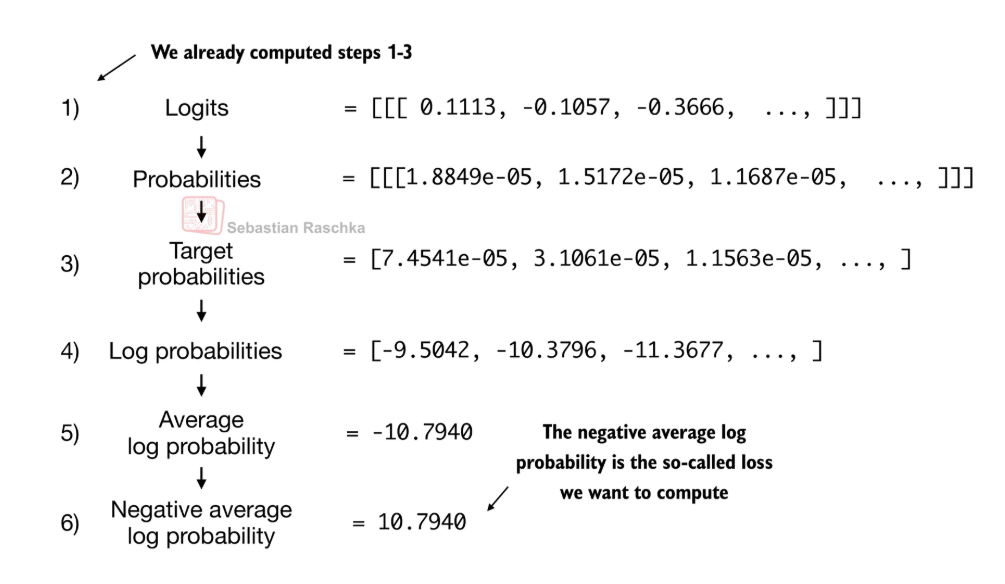

PyTorch has a built-in CrossEntropy Function.

In [22]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [23]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Logits:", logits_flat)
print("\nTargets:", targets_flat) #
print("\nFlattened logits:", logits_flat)
print("\nFlattened targets:", targets_flat)
print("\nFlattened logits shape:", logits_flat.shape)
print("\nFlattened targets shape:", targets_flat.shape)
# Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize

Logits: tensor([[-0.0755, -0.5547,  0.3469,  ...,  0.1516,  0.5014, -1.1591],
        [ 0.2560, -0.8153, -0.6563,  ..., -0.3624,  0.3843, -0.1578],
        [ 0.8914, -0.3270,  0.1289,  ...,  0.0780, -0.3121, -0.1172],
        [ 0.5330, -0.2725,  0.9215,  ..., -0.5423,  0.6963, -0.8689],
        [ 0.1810,  0.3803,  0.1455,  ..., -1.0161,  0.6445, -0.2403],
        [ 0.6139,  0.1547,  0.3889,  ..., -0.2706, -0.1842,  0.2356]])

Targets: tensor([ 3626,  6100,   345,  1107,   588, 11311])

Flattened logits: tensor([[-0.0755, -0.5547,  0.3469,  ...,  0.1516,  0.5014, -1.1591],
        [ 0.2560, -0.8153, -0.6563,  ..., -0.3624,  0.3843, -0.1578],
        [ 0.8914, -0.3270,  0.1289,  ...,  0.0780, -0.3121, -0.1172],
        [ 0.5330, -0.2725,  0.9215,  ..., -0.5423,  0.6963, -0.8689],
        [ 0.1810,  0.3803,  0.1455,  ..., -1.0161,  0.6445, -0.2403],
        [ 0.6139,  0.1547,  0.3889,  ..., -0.2706, -0.1842,  0.2356]])

Flattened targets: tensor([ 3626,  6100,   345,  1107,   588, 11311])

The reason we do this is because  the Cross-Entropy function in PyTorch expects :   


```
logits: (N, vocab_size)
targets: (N)
```




In [24]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8765)


##Perplexity

A concept related to the cross-entropy loss is the perplexity of an LLM.

The perplexity is simply the exponential of the cross-entropy loss.

In [25]:
perplexity = torch.exp(loss)
perplexity

tensor(52916.6055)

Perplexity tells us about how confused our Language Model is.

The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 52916.6055 words or tokens).


In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.


Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution



##Calculating the training and validation set losses

In [26]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [27]:
print(text_data[:50])
# Last 99 characters
print(text_data[-99:])

I HAD always thought Jack Gisburn rather a cheap g
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [28]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


Now, we ae going to divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training.

In [33]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
  # max_length is how many token_ids the model sees at once
  # if we set max_length as 10, it sees the first 10 token in the first step
  # and those first 10 are stored as a single row in the input_ids list
  # it's the same for target as well.
  # and stride is how much we will slide over in the next iteration of the sequence
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
    assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"


  # Use a sliding window to chunk the book into overlapping sequences of max_length
    for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
        return len(self.input_ids)

  def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [34]:
def create_dataloader_v1(txt, batch_size, max_length,
                         stride, shuffle, drop_last,
                         num_workers):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [38]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [39]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [41]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape) # (batch_size, sequence_length_of_the_sample)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])

Validation loader:
torch.Size([2, 254]) torch.Size([2, 254])


In [43]:
train_tokens = 0
# We are going to count the total tokens in the training and validation dataloader.

for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel() # tensor.numel() = number of elements inside the tensor

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)


Training tokens: 4572
Validation tokens: 508
All tokens: 5080


In [49]:
logits,logits.flatten(0,1)

(tensor([[[-0.0755, -0.5547,  0.3469,  ...,  0.1516,  0.5014, -1.1591],
          [ 0.2560, -0.8153, -0.6563,  ..., -0.3624,  0.3843, -0.1578],
          [ 0.8914, -0.3270,  0.1289,  ...,  0.0780, -0.3121, -0.1172]],
 
         [[ 0.5330, -0.2725,  0.9215,  ..., -0.5423,  0.6963, -0.8689],
          [ 0.1810,  0.3803,  0.1455,  ..., -1.0161,  0.6445, -0.2403],
          [ 0.6139,  0.1547,  0.3889,  ..., -0.2706, -0.1842,  0.2356]]]),
 tensor([[-0.0755, -0.5547,  0.3469,  ...,  0.1516,  0.5014, -1.1591],
         [ 0.2560, -0.8153, -0.6563,  ..., -0.3624,  0.3843, -0.1578],
         [ 0.8914, -0.3270,  0.1289,  ...,  0.0780, -0.3121, -0.1172],
         [ 0.5330, -0.2725,  0.9215,  ..., -0.5423,  0.6963, -0.8689],
         [ 0.1810,  0.3803,  0.1455,  ..., -1.0161,  0.6445, -0.2403],
         [ 0.6139,  0.1547,  0.3889,  ..., -0.2706, -0.1842,  0.2356]]))

In [55]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
  # Flattening is just removing the batch so that we can compare each row to the targets.

  return loss

def calc_loss_loader(model, data_loader, device, num_batches = None):
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
  return total_loss / num_batches

In [56]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")


print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(model, train_loader, device)
    val_loss   = calc_loss_loader(model, val_loader, device)


print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using cpu device.
Training loss: 10.97800318400065
Validation loss: 11.052067756652832


## Training an LLM

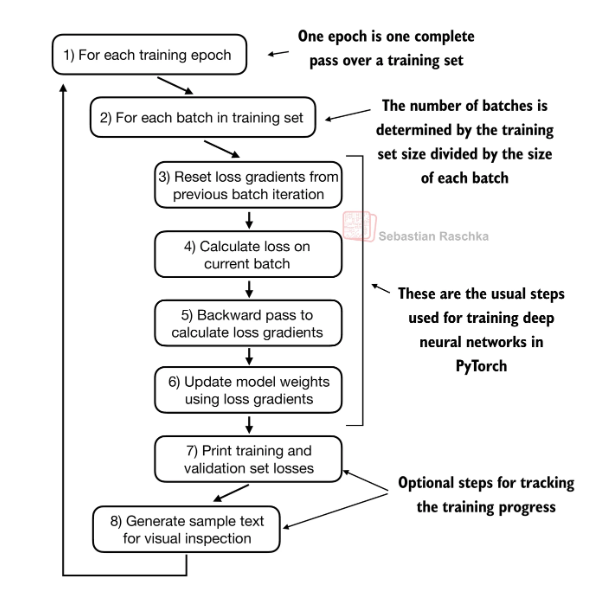